In [16]:
!pip install PyKomoran

In [17]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Bidirectional,  TimeDistributed, Dropout
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim.models import Word2Vec

from ast import literal_eval
from PyKomoran import *

In [19]:
#Load Data: case 1
df1 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_bad.csv', encoding='utf-8-sig')
df2 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_bad_new.csv', encoding='utf-8-sig')# 문법검사 안함. 2점 포함

s1 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_1_100000.csv', encoding = 'utf-8-sig', encoding_errors='ignore')
s2 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_10만_30만.csv', encoding = 'utf-8-sig', encoding_errors='ignore')
s3 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_30만_40만.csv', encoding = 'utf-8-sig', encoding_errors='ignore')
s4 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_40만_50만.csv', encoding = 'utf-8-sig', encoding_errors='ignore')
s5 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_50만_70만.csv', encoding = 'utf-8-sig', encoding_errors='ignore')
s6 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/re_tokenized_dog_good_1_70만.csv', encoding='utf-8-sig') #전처리 다시
s = pd.concat([s1, s2, s3, s4, s5, s6]).reset_index(drop=True)


df = pd.concat([df1, df2])
df['label'] = 0
s['label'] = 1 #긍정 데이터

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
#Load Data: case 2 문법 검사 안한 데이터만
"""s1 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_new(1).csv', encoding='utf-8-sig')
s2 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_new(2).csv', encoding='utf-8-sig')
df = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_bad_new.csv', encoding='utf-8-sig')

s = pd.concat([s1, s2])
s = s[s['point'] == 5]
s['label'] = 1 #긍정 데이터
df['label'] = 0 #부정 데이터
df"""

"s1 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_new(1).csv', encoding='utf-8-sig')\ns2 = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_good_new(2).csv', encoding='utf-8-sig')\ndf = pd.read_csv('/content/drive/MyDrive/논문 실습/review_data_tokenized/tokenized_dog_bad_new.csv', encoding='utf-8-sig')\n\ns = pd.concat([s1, s2])\ns = s[s['point'] == 5]\ns['label'] = 1 #긍정 데이터\ndf['label'] = 0 #부정 데이터\ndf"

In [21]:
#preprocess1. str을 리스트 형태로 바꿈
df = df.dropna(subset=['contents', 'tokenized'], axis=0).reset_index(drop=True) #NULL값 제거
df['tokenized'] = df['tokenized'].apply(literal_eval)
s = s.dropna(subset=['contents', 'tokenized'], axis=0).reset_index(drop=True) #NULL값 제거
s['tokenized'] = s['tokenized'].apply(literal_eval)

In [22]:
#n개 이하의 단어 삭제 후 샘플링
save_df = df
save_s = s

df = df.drop(df.loc[df['tokenized'].map(lambda x: len(x)) <= 1].index) #n개 이하 리스트 제거: 부정데이터
s = s.drop(s.loc[s['tokenized'].map(lambda x: len(x)) <= 5].index)

test = pd.concat([df, s])
s = s.sample(int(len(df) * 1.1))

df = pd.concat([df, s])
df = df[['contents','tokenized', 'label','point']]
df = df.dropna(subset=['contents'], axis=0).reset_index(drop=True) #NULL값 제거
df

,contents,tokenized,label,point
0,이 브랜드는 아니지만 전혀 입에 안 되네요. 우선 사기전에 집에 있는 멸치를 물에 ...,"[이, 브랜드, 는, 아니, 지만, 전혀, 입, 안, 되다, 우선, 사기전, 집, ...",0,1.0
1,신기고 벗기고 신발 빨고 놔두는 공간까지. 그냥 산책시키고 발딱 아주는 게 더 편할...,"[신기다, 고, 벗기다, 고, 신발, 빨다, 고, 놓아두다, 공간, 까지, 그냥, ...",0,1.0
2,이 사이트에서 산 건 아니고 타 사이트에서 샀는데. 정말 사구 후회한 제품이에요. ...,"[이, 사이트, 살다, ㄴ, 아니, 고, 타다, 아, 사이트, 사다, 정말, 사다,...",0,1.0
3,아직 어려서 못 쓸 줄 알았는데 잘습니다.. 근데 불량인지 물이 계속 뚝뚝뚝!떨어지...,"[아직, 어리다, 어서, 못, 쓰다, 알다, 는데, 잘다, 근데, 불량, 이, ㄴ지...",0,1.0
4,밑에 분은 이거 더 잘 먹는다고 했는데. 저의 강아지는 딱딱해서 그런지 거의 안 먹...,"[밑, 은, 더, 잘, 먹다, 는다고, 하다, 강아지, 는, 아서, 그렇다, ㄴ지,...",0,1.0
...,...,...,...,...
355678,잘 먹어요 우리 아가한테는 약간 작지만 그래도 좋아요,"[잘, 먹다, 어요, 아가, 는, 약간, 작다, 지만, 그래도, 좋다, 아요]",1,NaN
355679,울 아가가 출산해서 칼슘제가 필요했는데요 항상 이것만 먹여요.. 크기는 하지만 잘게...,"[아가, 출산, 아서, 칼슘, 필요, 는데요, 항상, 만, 먹이다, 크기, 는, 하...",1,5.0
355680,인을 꾸준히 먹여서 그런지 전보다 털도 부드러워지고 윤기가 흐르네요~~!!,"[인, 꾸준히, 먹다, 아서, 그렇다, ㄴ지, 전, 털, 도, 부드럽다, 어, 고,...",1,5.0
355681,생각보다 크기도 크고~ 소형견한텐 아주 딱 좋은 것 같아요 먹을 때 미끄러지지도 않...,"[생각, 크기, 도, 크다, 고, 소형, 견, ㄴ, 아주, 딱, 좋다, 같다, 아요...",1,5.0


In [37]:
df.to_csv('model_test_dataset.csv', encoding='utf-8-sig')

In [23]:
"""x_train, x_test, y_train, y_test = train_test_split(tokenized, label, test_size=0.1)
x_test_saved = x_test
y_test_saved = y_test"""
#train, test data split
train_set, test_set = train_test_split(df, test_size=0.1)

#전처리 하기 위해 dataframe을 리스트로 변환
x_train = train_set['tokenized'].tolist()
x_test = test_set['tokenized'].tolist()
y_train = train_set['label'].tolist()
y_test = test_set['label'].tolist()

리뷰의 최대 길이 : 470
리뷰의 평균 길이 : 16.702362283436525


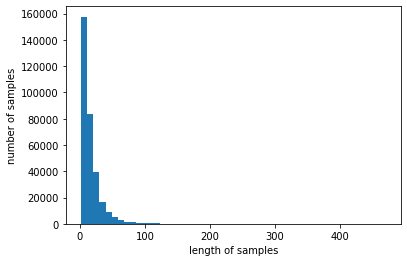

In [24]:
#리뷰 평균 길이
print('리뷰의 최대 길이 :',max(len(review) for review in x_train))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))
plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
#max_len 설정 값보다 작은 리뷰 비율
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 75
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 75 이하인 샘플의 비율: 98.6760966405718


In [26]:
#희귀단어 집합 확인
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
print(tokenizer.word_index)

threshold = 20
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

{'고': 1, '먹다': 2, '잘': 3, '도': 4, '어': 5, '이': 6, '좋다': 7, '는': 8, '는데': 9, '안': 10, '어요': 11, '아서': 12, '어서': 13, '아요': 14, '네요': 15, '하다': 16, '아': 17, '너무': 18, '같다': 19, '게': 20, '지': 21, '강아지': 22, '은': 23, '있다': 24, '면': 25, '냄새': 26, '좋아하다': 27, 'ㄴ': 28, '쓰다': 29, '다': 30, '먹이다': 31, '사다': 32, '보다': 33, '때': 34, '만': 35, '없다': 36, '되다': 37, '좀': 38, '사료': 39, '라': 40, '요': 41, '크다': 42, '구매': 43, '지만': 44, '간식': 45, '정말': 46, '나다': 47, '사용': 48, '더': 49, 'ㄴ데': 50, '그렇다': 51, '가격': 52, '향': 53, 'ㄴ지': 54, '그냥': 55, '니': 56, '다른': 57, '작다': 58, '아가': 59, '가지다': 60, '한': 61, '많이': 62, '껌': 63, 'ㅂ니다': 64, '아기': 65, '별로': 66, '구입': 67, '나': 68, '아주': 69, '다가': 70, '생각': 71, '더니': 72, '놀다': 73, '모르다': 74, '아직': 75, '제품': 76, '집': 77, '오다': 78, '처음': 79, '아니': 80, '괜찮다': 81, '많다': 82, '들다': 83, '애': 84, '아이': 85, '싸다': 86, '못': 87, '입': 88, '으면': 89, '주문': 90, '걸다': 91, '가다': 92, '알다': 93, '맞다': 94, '살다': 95, '아야': 96, '맛있다': 97, '강': 98, '털': 99, '고요': 100, '근데': 101, '조금': 102, '씹다': 

In [32]:
#word2vec 임베딩
tokenized = x_train + x_test
label = y_train + y_test
"""size = 임베딩 벡터의 차원, window = 컨텍스트 윈도우 크기, min_count = 단어의 최소 빈도, workers = 학습을 위한 프로세스 수, sg = 0 (CBOW)/1 (Skip-gram)"""
wmodel = Word2Vec(sentences = tokenized, size = 200, window = 6, min_count = 20, workers = 4, sg = 1)
word_vectors = wmodel.wv.vectors

#단어집합을 케라스 tokenizer 인자로 넘겨주고 text를 정수로 바꿈
#vocab size = Word2vec word_vector number
vocab_size = word_vectors.shape[0]
tokenizer = Tokenizer(vocab_size)  #vocab size 크기로 Tokenizer size 설정
tokenizer.fit_on_texts(x_train) #x_train data로 tokinizer 학습

#x_train data text를 number vector로 변환
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

#y_train data를 np형태로 변환
y_train = np.array(y_train)
y_test = np.array(y_test)

#padding과정을 통해 data 길이를 max_len=75 길이로 고정
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [33]:
embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[word_vectors], trainable=False))
model.add(LSTM(hidden_units, return_sequences=True)) #시퀸스 분류를 위한 LSTM
model.add(LSTM(hidden_units, return_sequences=True))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
4001/4002 [============================>.] - ETA: 0s - loss: 0.3067 - acc: 0.8682
Epoch 1: val_acc improved from -inf to 0.90992, saving model to best_model.h5
4002/4002 [==============================] - 82s 19ms/step - loss: 0.3067 - acc: 0.8682 - val_loss: 0.2304 - val_acc: 0.9099
Epoch 2/15
4000/4002 [============================>.] - ETA: 0s - loss: 0.2126 - acc: 0.9167
Epoch 2: val_acc improved from 0.90992 to 0.92265, saving model to best_model.h5
4002/4002 [==============================] - 75s 19ms/step - loss: 0.2126 - acc: 0.9167 - val_loss: 0.2056 - val_acc: 0.9227
Epoch 3/15
3999/4002 [============================>.] - ETA: 0s - loss: 0.1841 - acc: 0.9294
Epoch 3: val_acc improved from 0.92265 to 0.92963, saving model to best_model.h5
4002/4002 [==============================] - 76s 19ms/step - loss: 0.1841 - acc: 0.9294 - val_loss: 0.1839 - val_acc: 0.9296
Epoch 4/15
3999/4002 [============================>.] - ETA: 0s - loss: 0.1642 - acc: 0.9381
Epoch 4: val_

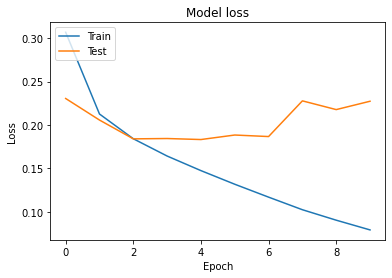

In [34]:
# 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

1112/1112 [==============================] - 11s 8ms/step - loss: 0.1894 - acc: 0.9333

 테스트 정확도: 0.9333


In [36]:
#긍정 데이터에 대해 잘 예측하는지
good = s.sample(100000, replace=True)
new_review_label = good
new_review_label = new_review_label[['contents','tokenized', 'label','point']]

total_test = tokenizer.texts_to_sequences(new_review_label['tokenized'].tolist())
Y_test = new_review_label['label'].tolist()
Y_test = np.array(Y_test)

total_test = pad_sequences(total_test, maxlen=max_len)

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(total_test, Y_test)[1]))

3125/3125 [==============================] - 19s 6ms/step - loss: 0.1097 - acc: 0.9618

 테스트 정확도: 0.9618


In [43]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [44]:
#모델 실제 사용하기
komoran = Komoran(DEFAULT_MODEL['LIGHT'])
target_tags = ['NNG', 'VV', 'VA', 'MM', 'MAG', 'VCP', 'VCN', 'MAJ', 'JX','EC','NNP'] #긍정(부정)지정사, 부사, 보조사

def sentiment_predict(new_sentence):
  taged = komoran.pos(new_sentence) #리스트 [저번/NNG(0,2),에/JKB(2,3),...] 이런형식
  appended = []

  for i in range(len(taged)):
    if taged[i].get_pos() in target_tags:
      tmp = str(taged[i].get_morph())
      if taged[i].get_pos() in ['VA', 'VV']:
        tmp = tmp + '다'
      appended.append(tmp)

  new_sentence = appended
  encoded = load_tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  return score

In [46]:
total_review = new_review_label['contents'].tolist()
print(total_review[3])
sentiment_predict(total_review[3])

울 아이들 참 잘 먹네요. 사료에 쓱쓱 비벼주면 게 눈 감추듯 순식간에 거덜 납디다.. 평소에 먹던 캔 이 있어서 우선 개를 주문했는데, 오늘로 쫑 났네요. 먹던 거 다 먹고 담 주에 간식이랑 많이 시켜줘야겠어요. 기호성도 좋고, 강아지 캔 뜯으면 특유의 비린내가 있었는데, 요건 냄새도 전혀 없고, 깔끔한 포장이 참 맘에 듭니다. 많이 파세요 ^^


0.9979547262191772